In [120]:
import numpy as np
import matplotlib.pyplot as plt
import pylcp
import lmfit
from pylcp.common import progressBar

In [194]:
laser_det = 0.
ham_det = -2.
s = 1.25

laserBeams = {}
laserBeams['$\\sigma^+\\sigma^-$'] = pylcp.laserBeams([
    {'kvec':np.array([0., 0., -1.]), 'pol':+1,
     'pol_coord':'spherical', 'delta':laser_det, 's':s},
    {'kvec':np.array([0., 0., +1.]), 'pol':+1,
     'pol_coord':'spherical', 'delta':laser_det, 's':s},
    {'kvec':np.array([0., -1., 0.]), 'pol':+1,
     'pol_coord':'spherical', 'delta':laser_det, 's':s},
    {'kvec':np.array([0., +1., 0.]), 'pol':+1,
     'pol_coord':'spherical', 'delta':laser_det, 's':s},
    {'kvec':np.array([-1., 0., 0.]), 'pol':+1,
     'pol_coord':'spherical', 'delta':laser_det, 's':s},
    {'kvec':np.array([+1., 0., 0.]), 'pol':+1,
     'pol_coord':'spherical', 'delta':laser_det, 's':s}
    ], beam_type=pylcp.infinitePlaneWaveBeam)

In [206]:
laserBeams['$\\sigma^+\\sigma^-$'].pol()

array([[ 1.00000000e+00+0.000000e+00j,  0.00000000e+00+0.000000e+00j,
         0.00000000e+00+0.000000e+00j],
       [ 0.00000000e+00+0.000000e+00j,  0.00000000e+00+0.000000e+00j,
         1.00000000e+00+0.000000e+00j],
       [ 3.06161700e-17+5.000000e-01j,  7.07106781e-01+0.000000e+00j,
         3.06161700e-17-5.000000e-01j],
       [ 3.06161700e-17-5.000000e-01j,  7.07106781e-01+0.000000e+00j,
         3.06161700e-17+5.000000e-01j],
       [-5.00000000e-01-6.123234e-17j,  7.07106781e-01+0.000000e+00j,
        -5.00000000e-01+6.123234e-17j],
       [ 5.00000000e-01+0.000000e+00j,  7.07106781e-01+0.000000e+00j,
         5.00000000e-01+0.000000e+00j]])

In [196]:
laserBeams['$\\sigma^+\\sigma^-$'].total_electric_field_gradient(np.array([0., 0., 0.]), 0.)
magField = lambda R: np.zeros(R.shape)

# Hamiltonian for F=0->F=1
Hg, Bgq = pylcp.hamiltonians.singleF(F=0, gF=0, muB=1)
He, Beq = pylcp.hamiltonians.singleF(F=1, gF=1, muB=1)
dijq = pylcp.hamiltonians.dqij_two_bare_hyperfine(0, 1)
ham_F0_to_F1 = pylcp.hamiltonian(Hg, He - ham_det*np.eye(3), Bgq, Beq, dijq)

In [210]:
pylcp.hamiltonians.dqij_two_bare_hyperfine(1, 1)

array([[[ 0.        ,  0.70710678,  0.        ],
        [ 0.        ,  0.        ,  0.70710678],
        [ 0.        ,  0.        ,  0.        ]],

       [[-0.70710678,  0.        ,  0.        ],
        [ 0.        , -0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.70710678]],

       [[ 0.        ,  0.        ,  0.        ],
        [-0.70710678,  0.        ,  0.        ],
        [ 0.        , -0.70710678,  0.        ]]])

In [197]:
obe={}
rateeq={}

# Define a v axis:
v = np.arange(-5.0, 5.1, 0.125)

for jj, key in enumerate(laserBeams.keys()):
    print('Working on %s:' % key)
    rateeq[key] = pylcp.rateeq(laserBeams[key], magField, ham_F0_to_F1)
    obe[key] = pylcp.obe(laserBeams[key], magField, ham_F0_to_F1,
                         transform_into_re_im=False, include_mag_forces=False)

    # Generate a rateeq model of what's going on:
    rateeq[key].generate_force_profile(
        [np.zeros(v.shape), np.zeros(v.shape), np.zeros(v.shape)],
        [np.zeros(v.shape), np.zeros(v.shape), v],
        name='molasses'
    )

    obe[key].generate_force_profile(
        [np.zeros(v.shape), np.zeros(v.shape), np.zeros(v.shape)],
        [np.zeros(v.shape), np.zeros(v.shape), v],
        name='molasses', deltat_tmax=2*np.pi*100, deltat_v=4, itermax=1000,
        progress_bar=True,
    )

Working on $\sigma^+\sigma^-$:
Completed in 13.80 s.                                              


Text(0, 0.5, '$f/(\\hbar k \\Gamma)$')

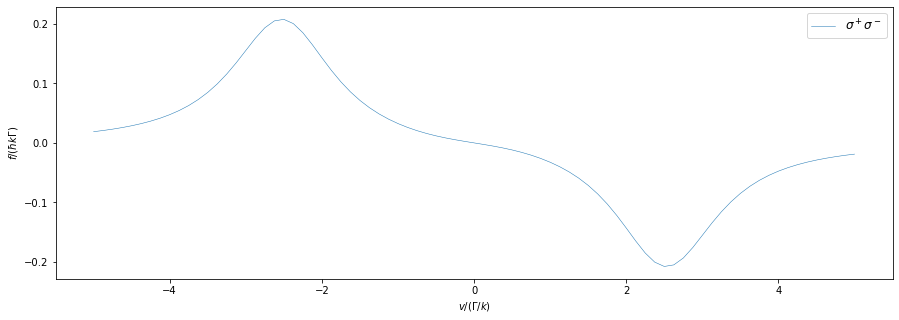

In [198]:
fig, ax = plt.subplots(1, 1, num='Optical Molasses F=0->F1', figsize=(15, 5))
for jj, key in enumerate(laserBeams.keys()):
    ax.plot(obe[key].profile['molasses'].V[2],
               obe[key].profile['molasses'].F[2],
               label=key, linewidth=0.5, color='C%d'%jj)
ax.legend(fontsize=12)
ax.set_xlabel('$v/(\Gamma/k)$')
ax.set_ylabel('$f/(\hbar k \Gamma)$')

In [199]:
obe[key].profile['molasses'].Neq[80,:]

array([0.78796622, 0.02181235, 0.18726725, 0.00295417])

In [208]:
obe[key].profile['molasses'].Neq[40,:]

array([0.78813508, 0.02118649, 0.16949194, 0.02118649])